# LSTM parser for the French Treebank

This notebook trains a parser for the French Treebank. The parser is inspired by the one presented in Tsuruoka e.a. (2015), though it uses LSTM instead of conditional random fields. Like Tsuruoka e.a. (2015), the parser operates by a type of iterative chunking, continuing until it finds an analysis of the entire sentence.


##### Load library packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle


from keras.models import Model, load_model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import backend as K
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


### Read the parser actions file

The parser actions file contains triples of the form `Prosody|Formula|ParserAction`, where `Prosody` is either a word or a binary tree of words, `Formula` is formula from the TLGbank (simplified), and `ParserAction` gives the correct chunks for the current sequence, with `O` meaning a formula is outside of all chuncks.

In [2]:
def read_parsedata(file):
    with open(file, 'r') as f:
        vocabulary = set()
        vnorm = set()
        actionset = set()
        superset = set()
        sentno = 0
        maxlen = 0
        allpros = []
        allforms = []
        allactions = []
        for line in f:
            line = line.strip().split()
            length = len(line)
            sentforms = []
            sentpros = []
            sentactions = []
            if (length > maxlen):
                maxlen = length
            for l in range(length):
                item = line[l].split('|')
                pros = item[0]
                form = item[1]
                action = item[2]
                if not(pros.startswith("p(")):
                    nword = normalize_word(pros)
                    vocabulary.add(pros)
                    vnorm.add(nword)
                pros = pros.replace("p(0,", "")
                pros = pros.replace("p(1,", "")
                pros = pros.replace(")", "")
                pros = pros.split(",")
                superset.add(form)
                actionset.add(action)
                sentforms.append(form)
                sentpros.append(pros)
                sentactions.append(action)
            allpros.append(sentpros)
            allforms.append(sentforms)
            allactions.append(sentactions)
    X = np.asarray(allpros)
    Y = np.asarray(allforms)
    Z = np.asarray(allactions)
    return X, Y, Z, vocabulary, vnorm, superset, actionset, maxlen

In [3]:
# sentences with verified parses
# number of sentences, train: 9449, test: 3150, dev: 3150
pros, forms, actions, vocabulary, vnorm, superset, actionset, maxLen = read_parsedata('parse_silver.txt')

In [4]:

print("Longest sentence   : ", maxLen)
print("Number of actions : ", len(actionset), actionset)
print("Number of supertags: ", len(superset), superset)


Longest sentence   :  266
Number of actions :  58 {'gap_i2', 'prod_wl1', 'prod_dr1', 'gap_e1', 'e_endd1', 'dr2', 'e_endd2', 'e_end_l2', 'e_end1', 'a_dit2', 'c_r_lnr2', 'prod_dr2', 'c_l_lnr3', 'wpop_vpi1', 'e_end_r_lnr1', 'prod_c1', 'prod_e1', 'prod_cl2', 'se_dit1', 'wr_a1', 'prod_c2', 'c_l_lnr2', 'dl1', 'e_start_l1', 'se_dit2', 'dit_np1', 'prod_w1', 'prod_i2', 'c_r_lnr1', 'ef_start1', 'wpop1', 'let2', 'gap_i1', 'prod_cl1', 'ef_start_iv1', 'e_end2', 'dl2', 'dr1', 'e_start1', 'e_end_l_lnr1', 'c_l_lnr1', 'wpop_vp1', 'a_dit1', 'prod_i1', 'c_r_lnr3', 'e_end_l1', 'wr1', 'dit_np2', 'O', 'a_dit_se1', 'a_dit_se2', 'gap_c1', 'let1', 'wr_a2', 'wpop_vpi2', 'e_end_l_lnr2', 'e_end_r_lnr2', 'wr2'}
Number of supertags:  698 {'dl(0,dr(0,s,dia(1,box(1,dl(0,np,s)))),dr(0,s,box(1,dia(1,dl(0,np,s)))))', 'dl(0,cl_y,dl(1,s,s))', 'dr(0,dl(0,cl_r,dl(0,dl(0,n,n),dl(0,n,n))),pp)', 'dr(0,dr(0,pp,s),pp)', 'dr(0,dr(0,s,dl(0,np,s)),pp)', 'dl(0,dr(0,pp,np),dl(0,n,n))', 'dr(0,dr(0,dl(0,np,s),np),dl(0,n,n))', 'dl(0,dr(

## Create auxiliary mappings

Load vector embeddings for the vocabulary. Create mappings from words, formulas and actions integers and back.

In [5]:
wv = KeyedVectors.load_word2vec_format('../wang2vec/frwiki_cwindow50_10.bin', binary=True)
veclength = 50

In [6]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

Create vector mapping for all words in the vocabulary, using a zero vector for unknown words. Words are normalized before lookup (removing capitalization, etc.)

In [7]:
word_to_vec_map = {}
unknowns = set()
invoc = 0

for w in vocabulary:
    wn = normalize_word(w)
    wr = remove_prefix(wn, "-t-")
    wr = remove_prefix(wr, "-")
    try:
        vec = wv[wr]
        invoc = invoc + 1
    except:
        unknowns.add(w)
        vec = np.zeros(veclength)
    word_to_vec_map[w] = vec

print('Unknowns: ', len(unknowns))
print('In vocabulary: ', invoc)

Unknowns:  6741
In vocabulary:  21556


Compute a vector meaning for a complex prosodic term by taking the average for all words having an embedding. Other solutions, such as simple addition, are possible. An alternative would be to keep track only of the head word in each prosodic term (this will greatly reduce the embedding size and may work well)

In [8]:
def pros_to_vec(pros):
    vec = np.zeros(veclength)
    numw = 0
    for w in pros:
        wn = normalize_word(w)
        try:
            wvec = wv[wn]
            vec = vec + wvec
            numw = numw + 1
        except:
            pass
    if numw == 0:
        numw = 1
    return vec/numw    

Looks at some examples

In [9]:
print(pros[113])
print(len(pros[113]))
print(forms[113])
print(actions[113])
print(len(actions[113]))

[['Il'], ['y', 'a', 'quelques', 'jours'], ['', '', 'une', 'soixantaine', 'de', 'rebelles', 'présumés'], ['', '', 'dont', 'certains', 'étaient', 'armés'], ['', '', 'ont'], ['été', 'transférés', 'à', 'Abidjan'], ['.']]
7
['np', 'dl(0,np,dr(0,s,s))', 'np', 'dl(0,np,np)', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dl(0,np,s)', 'dl(0,s,txt)']
['dl1', 'dl2', 'dl1', 'dl2', 'dr1', 'dr2', 'O']
7


In [10]:
print(pros_to_vec(pros[113][0]))
print(pros[113][0])
print(wv['il'])

[ 0.06135423 -0.13131003 -0.18451238 -0.25952235 -0.20443681  0.28091779
  0.12621945  0.15473232  0.09866685  0.02807902 -0.31461665 -0.08482077
 -0.05280184 -0.12457576 -0.39251816  0.03320421 -0.08924808 -0.59473646
 -0.16613822 -0.20295529  0.06712979  0.16169645 -0.13465753 -0.02375351
 -0.30984667  0.02895044 -0.03812085 -0.15557894 -0.42134857  0.2752746
 -0.63396919 -0.11106327  0.27074042  0.21478277 -0.09659664  0.44096583
 -0.02110181 -0.10309666  0.22942159 -0.05130152  0.44929028  0.04754487
  0.18998609 -0.02927026  0.43349707  0.20478503  0.25512281 -0.22025017
 -0.22031641  0.02538358]
['Il']
[ 0.06135423 -0.13131003 -0.18451238 -0.25952235 -0.20443681  0.28091779
  0.12621945  0.15473232  0.09866685  0.02807902 -0.31461665 -0.08482077
 -0.05280184 -0.12457576 -0.39251816  0.03320421 -0.08924808 -0.59473646
 -0.16613822 -0.20295529  0.06712979  0.16169645 -0.13465753 -0.02375351
 -0.30984667  0.02895044 -0.03812085 -0.15557894 -0.42134857  0.2752746
 -0.63396919 -0.1110

Create the mappings to and from integers

In [11]:
word_to_index, index_to_word = indexify(vocabulary)
form_to_index, index_to_form = indexify(superset)
action_to_index, index_to_action = indexify(actionset)

## Create model inputs


In [12]:
numActions = len(index_to_action) + 1
numSuperClasses = len(index_to_form) + 1

Y = lists_to_indices(actions, action_to_index, maxLen)
X = lists_to_indices(forms, form_to_index, maxLen)

In [15]:
print(len(vocabulary))
print(forms[0])
print(pros[0])
print(X[0])

28297
['np', 'dr(0,dl(0,np,np),pp)', 'dr(0,pp,np)', 'np', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dr(0,dl(0,n,n),dl(0,n,n))', 'dl(0,n,n)', 'let', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'dr(0,n,n)', 'n', 'dr(0,dl(0,n,n),np)', 'dr(0,np,n)', 'n', 'let', 'dr(0,dl(1,s,s),n)', 'dr(0,n,n)', 'n', 'let', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),pp)', 'dr(0,dl(1,s,s),n)', 'n', 'let', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dl(0,s,txt)']
[['Six'], ["d'"], ['entre'], ['eux'], ['', ''], ['seulement'], ['blessés'], ['', ''], ['ont'], ['pu'], ['se'], ['réfugier'], ['sur'], ["l'"], ['autre'], ['rive'], ['de'], ['la'], ['Nipoué'], ['', ''], ['en'], ["Côte-d'"], ['Ivoire'], ['', ''], ['avant'], ["d'"], ['être'], ['transférés'], ['à'], ['man'], ['', ''], ['dans'], ['un'], ['hôpital'], ['.']]
[ 691.  354.  694.  691.  321.  398.  212.  191. 

Keep 20% of the sentences as test data

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Convert integer outputs to one-hot representations

In [145]:
Y_train_oh = to_categorical(Y_train, numActions)

## Define the model

As a baseline, use the simplest possible model with access only to the formulas but no information about the words.

In [146]:
sentence_indices = Input(shape = (maxLen,), dtype = 'int32')

In [147]:
emb = Embedding(numSuperClasses,64,trainable=True,mask_zero=True)(sentence_indices)

In [148]:
LSTM1 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(emb)
LSTM2 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(LSTM1)

In [149]:
Act =  TimeDistributed(Dense(numActions,kernel_constraint=max_norm(5.),activation='softmax'))(LSTM2)

Define the same model using a function 

In [150]:
def parse_model(input_shape, num_super, num_actions):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    emb = Embedding(numSuperClasses,64,trainable=True,mask_zero=True)(sentence_indices)
    LSTM1 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(emb)
    LSTM2 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(LSTM1)
    Act =  TimeDistributed(Dense(numActions,kernel_constraint=max_norm(5.),activation='softmax'))(LSTM2)
    model = Model(inputs=sentence_indices,outputs=Act)
    
    return model

In [151]:
model = parse_model((maxLen,), numSuperClasses, numActions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 266)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 266, 64)           44736     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 266, 256)          197632    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 266, 256)          394240    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 266, 59)           15163     
Total params: 651,771
Trainable params: 651,771
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train on the silver data

In [155]:
history = model.fit(X_train, Y_train_oh, epochs=5, batch_size=16, shuffle=True, validation_split=0.25)

Train on 108695 samples, validate on 36232 samples
Epoch 1/5
108695/108695 [==============================] - 7438s 68ms/step - loss: 0.1293 - acc: 0.9545 - val_loss: 0.1095 - val_acc: 0.9610
Epoch 2/5
108695/108695 [==============================] - 7457s 69ms/step - loss: 0.1078 - acc: 0.9610 - val_loss: 0.1041 - val_acc: 0.9627
Epoch 3/5
108695/108695 [==============================] - 10488s 96ms/step - loss: 0.1007 - acc: 0.9631 - val_loss: 0.0974 - val_acc: 0.9648
Epoch 4/5
108695/108695 [==============================] - 13218s 122ms/step - loss: 0.0965 - acc: 0.9646 - val_loss: 0.0958 - val_acc: 0.9646
Epoch 5/5
108695/108695 [==============================] - 12970s 119ms/step - loss: 0.0940 - acc: 0.9652 - val_loss: 0.0954 - val_acc: 0.9652


#### Plot training versus validation loss and accuracy

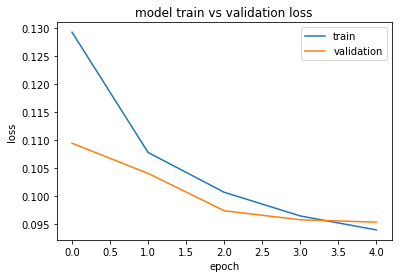

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

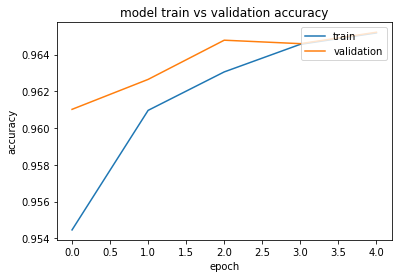

In [157]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##### Save the silver model

In [158]:
model.save('silver_parse.h5')

### Prepare the gold data and train the pretrained model

In [168]:
# sentences with verified parses
# number of sentences, train: 9449, test: 3150, dev: 3150
pros, forms, actions, goldvoc, goldvnorm, goldsuperset, goldactionset, goldml = read_parsedata('parse_gold.txt')

In [169]:
maxLen = 266

In [170]:
Y = lists_to_indices(actions, action_to_index, maxLen)
X = lists_to_indices(forms, form_to_index, maxLen)

In [171]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [172]:
Y_train_oh = to_categorical(Y_train, numActions)

In [173]:
history = model.fit(X_train, Y_train_oh, epochs=5, batch_size=32, shuffle=True, validation_split=0.25)

Train on 31830 samples, validate on 10611 samples
Epoch 1/5
31830/31830 [==============================] - 1803s 57ms/step - loss: 0.0906 - acc: 0.9667 - val_loss: 0.0831 - val_acc: 0.9693
Epoch 2/5
31830/31830 [==============================] - 1985s 62ms/step - loss: 0.0866 - acc: 0.9680 - val_loss: 0.0844 - val_acc: 0.9684
Epoch 3/5
31830/31830 [==============================] - 3100s 97ms/step - loss: 0.0842 - acc: 0.9688 - val_loss: 0.0834 - val_acc: 0.9690
Epoch 4/5
31830/31830 [==============================] - 1716s 54ms/step - loss: 0.0822 - acc: 0.9695 - val_loss: 0.0830 - val_acc: 0.9691
Epoch 5/5
31830/31830 [==============================] - 1759s 55ms/step - loss: 0.0800 - acc: 0.9702 - val_loss: 0.0835 - val_acc: 0.9690


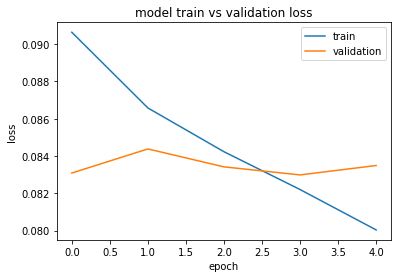

In [174]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

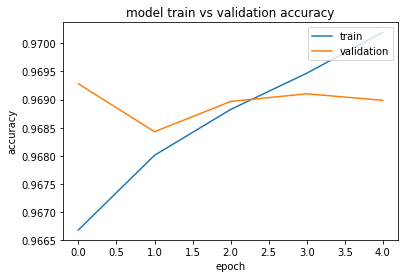

In [175]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Save everything

In [176]:
model.save('parse.h5')

In [177]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [178]:
save_obj(word_to_index, 'word_to_index')
save_obj(index_to_word, 'index_to_word')
save_obj(form_to_index, 'form_to_index')
save_obj(index_to_form, 'index_to_form')
save_obj(action_to_index, 'action_to_index')
save_obj(index_to_action, 'index_to_action')


In [41]:
def simple_formula(formula, form_to_index):
    oldformula = formula
    formula = formula.replace('_ppart', '')
    formula = formula.replace('_inf', '')
    formula = formula.replace('_pass', '')
    formula = formula.replace('_de', '')
    formula = formula.replace('_par', '')
    formula = formula.replace('_a', '')
    formula = formula.replace('_q', '')
    if not formula == oldformula:
        form_to_index[oldformula] = form_to_index[formula]
    return formula, form_to_index

In [42]:
fset = form_to_index.keys()
for f in sset:
    if f not in fset:
        sf, form_to_index = simple_formula(f, form_to_index)

KeyError: 'dr(0,dr(0,dr(0,s,s),dl(0,np,s)),np)'

In [36]:
X_test_indices = lists_to_indices(X_test, form_to_index, maxLen)

Unknown:  dr(0,dl(0,n,n),pp_a)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_a)
Unknown:  dr(0,pp_a,n)
Unknown:  dr(0,np,pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,box(1,pp_de))))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),pp_de),np)
Unknown:  dr(0,dl(0,np,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,pp_de,pp_a),np)
Unknown:  dr(0,dl(0,np,np),s_q)
Unknown:  dr(0,s_q,np)
Unknown:  dr(0,dl(0,np,s),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s_inf)),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0

Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_a)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dr(0,dl(0,np,s),dl(0,np,s_inf)),dl(0,n,n))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(1,s,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),dr(0,dl(0,cl_r,dl(0,np,s)),dia(1,box(1,pp_de))))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_de)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,box(1,pp_de))))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),s_q),pp_de)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s_inf)),pp_a)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,s_whq,dr(0,s,dia(1,box(1,np))))
Unknown:  dr(0,dr(0,s,np),

Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dr(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_ppres))
Unknown:  dr(0,dl(0,np,s_ppres),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_ppres))
Unknown:  dr(0,dl(0,np,s_ppres),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,n,pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,pp_a,n)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),dl(0,np,s_inf)),np)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_

Unknown:  dr(0,dl(1,s,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,pp_par,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,pp_par,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),pp)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(1,s,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,bo

In [179]:
test = X[0:1000]

In [195]:
print(test[0])

[ 344.  688.    2.  344.  453.  418.  207.  412.  122.  122.  502.  237.
    2.  423.  329.  206.  508.  423.  206.  412.  273.  329.  206.  412.
  415.  122.  122.  553.  273.  206.  412.    2.  423.  206.  145.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.   

In [180]:
pred = model.predict(test)

In [184]:
print(pred[0])

[[  4.32639688e-11   7.85440335e-09   7.63172192e-09 ...,   4.50909283e-07
    1.06567839e-08   3.92462425e-07]
 [  4.73737938e-10   1.09492134e-06   6.85844270e-06 ...,   2.33493461e-06
    3.95394363e-06   9.07113318e-09]
 [  4.46065407e-10   4.34663832e-07   2.42116922e-08 ...,   4.70352234e-07
    8.22737931e-08   1.77212735e-06]
 ..., 
 [  1.14860632e-06   1.84543198e-04   1.68097508e-03 ...,   3.12840343e-02
    7.09003070e-05   2.08398633e-05]
 [  1.14860632e-06   1.84543198e-04   1.68097508e-03 ...,   3.12840343e-02
    7.09003070e-05   2.08398633e-05]
 [  1.14860632e-06   1.84543198e-04   1.68097508e-03 ...,   3.12840343e-02
    7.09003070e-05   2.08398633e-05]]


In [181]:
allpredictions = []
for i in range(len(test)):
    predictions = []
    for j in range(len(forms[i])):
        num = np.argmax(pred[i][j])
        print(forms[i][j] + '|' + index_to_action[num])
        predictions.append(index_to_action[num])
    allpredictions.append(predictions)
    print('===')

np|O
dr(0,dl(0,np,np),pp)|O
dr(0,pp,np)|O
np|dr2
dr(0,dl(0,np,np),dl(0,n,n))|O
dr(0,dl(0,n,n),dl(0,n,n))|dr1
dl(0,n,n)|dr2
let|let1
dr(0,dl(0,np,s),dl(0,np,s))|let2
dr(0,dl(0,np,s),dl(0,np,s))|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
dr(0,n,n)|dr1
n|dr2
dr(0,dl(0,n,n),np)|O
dr(0,np,n)|dr1
n|dr2
let|let1
dr(0,dl(1,s,s),n)|let2
dr(0,n,n)|dr1
n|dr2
let|let1
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|let2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),pp)|O
dr(0,dl(1,s,s),n)|dr1
n|dr2
let|let1
dr(0,pp,np)|let2
dr(0,np,n)|dr1
n|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,np),pp)|dr1
pp|dr2
dr(0,dl(0,np,np),dl(0,n,n))|dr1
dl(0,n,n)|dr2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|dr1
np|dr2
dr(0,dl(1,s,s),n)|dr1
n|dr2
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,n

===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dl(0,np,s)|O
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|dr1
n|dr2
dl(0,np,s)|O
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),dl(0,np,s)),pp)|O
dr(0,pp,np)|dr1
np|dr2
dl(0,np,s)|O
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),dl(0,np,s)),pp)|dr1
pp|dr2
dl(0,np,s)|O
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(1,s,s)|O
dl(0,s,txt)|O
===
np|dl1
dl(0,np,s)|dl2
dl(1,s,s)|O
dl(0,s,txt)|O
===
s|dl1
dl(1,s,s)|dl2
dl(0,s,txt)|O
===
s|dl1
dl(0,s,txt)|dl2
===
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,np),n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,n

dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dl(0,n,n)|O
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),pp)|O
dr(0,pp,n)|O
n|dl1
dl(0,n,n)|dl2
dl(0,n,n)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|O
dr(0,dl(0,np,np),np)|dr1
np|dr2
dl(0,dl(0,np,np),dl(0,np,np))|O
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dl(0,n,n)|O
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),pp)|O
dr(0,pp,n)|O
n|dl1
dl(0,n,n)|dl2
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|O
dl(0,np,np)|dl1
dl(0,dl(0,np,np),dl(0,np,np))|dl2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dl(0,n,n)|O
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),pp)|dr1
pp|dr2
dl(0,n,n)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|dl1
dl(0,np,np)|dl2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dl(0,n,n)|dl1
dl(1,dl(0,n,n),dl(0,n,n))|dl2
dl(0,n,n)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|dr1
np|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(

s|dl1
dl(1,s,s)|dl2
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dl(0,np,s)|O
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),s)|dr1
s|dr2
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dl(0,np,s)|O
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
s|O
dr(0,dl(0,s,s),s)|O
np|dl1
dl(0,np,s)|dl2
dl(0,s,txt)|O
===
dr(0,s,s)|dr1
s|dr2
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dl(0,np,s)|O
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
s|O
dr(0,dl(0,s,s),s)|dr1
s|dr2
dl(0,s,txt)|O
===
dr(0,s,s)|dr1
s|dr2
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dl(0,np,s)|O
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
s|dl1
dl(0,s,s)|dl2
dl(0,s,txt)|O
===
dr(0,s,s)|O
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s

dl(0,n,n)|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|O
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,np),n)|dr1
n|dr2
dr(0,dl(1,s,s),np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,n,n),np)|O
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,np),n)|dr1
n|dr2
dr(0,dl(0,s,s),s)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,n,n),n)|dr1
n|dr2
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,np)|O
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,np),n)|dr1
n|dr2
dr(0,dl(0,np,np),np)|O
dr(0,np,np)|O
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,np),np)|O
dr(0,np,n)|O
dr(0,n,n)|dr1
n|dr2
dr(0,dl(0,n,n),np)|dr1
np|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|dr1
n|dr2
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|O
np|dl1
dl(0,np,np)|dl2
dr(0,dl(1,s,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|O
np|dl1
dl(0,np,np)|dl2
dr(0,dl(0,s,s),s)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np

dr(0,dl(0,p(0,np,np),p(0,np,dia(0,box(0,np)))),p(0,np,np))|O
np|O
dr(0,np,n)|O
n|O
dl(0,n,n)|e_end_l_lnr1
dl(0,dl(0,dia(0,box(0,n)),n),dl(0,n,n))|e_end_l_lnr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|prod_i1
np|O
dr(0,dl(0,p(0,np,np),p(0,np,dia(0,box(0,np)))),p(0,np,np))|O
np|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
p(0,np,np)|O
dr(0,dl(0,p(0,np,np),p(0,np,dia(0,box(0,np)))),p(0,np,np))|O
np|O
dr(0,np,n)|dr1
n|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
p(0,np,np)|O
dr(0,dl(0,p(0,np,np),p(0,np,dia(0,box(0,np)))),p(0,np,np))|O
np|O
np|ef_start1
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
p(0,np,np)|O
dr(0,dl(0,p(0,np,np),p(0,np,dia(0,box(0,np)))),p(0,np,np))|O
p(0,np,np)|O
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
p(0,np,np)|dl1
dl(0,p(0,np,np),p(0,np,dia(0,box(0,np))))|dl2
dl(0,s,txt)|O
===
dr(0,dr(0,s,np),dl

n|O
dl(0,n,n)|dl1
dl(0,dl(0,n,n),dl(0,n,n))|dl2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|dr1
n|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|dr1
np|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|dl1
dl(0,np,s)|dl2
dl(0

dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
np|dl1
dl(0,np,s)|dl2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|dr1
s|dr2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|O
dr(0,dl(0,np,s),s)|dr1
s|dr2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|O
np|dl1
dl(0,np,s)|dl2
dl(0,s,txt)|O
===
s|O
dr(0,dl(0,s,s),s)|dr1
s|dr2
dl(0,s,txt)|O
===
s|dl1
dl(0,s,s)|dl2
dl(0,s,txt)|O
===
s|dl1
dl(0,s,txt)|dl2
===
np|O
dr(0,dl(0,np,s),s)|O
dr(0,s,s)|O
np|O
dr(0,dr(0,dl(0,np,s),s),pp)|O
dr(0,pp,np)|O
np|O
dr(0,dl(0,np,np),n)|O
dr(0,n,n)|O
n|O
dr(0,dl(0,n,n),n)|dr1
n|dr2
dr(0,dl(0,n,n),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dr

cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,cl_r,dl(0,np,s)))|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,n,n),n)|O
n|dl1
dl(0,n,n)|dl2
dr(0,dl(0,n,n),dl(0,np,s))|O
let|wr1
dl(1,s,s)|wr2
let|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),np),pp)|O
dr(0,pp,np)|dr1
np|dr2
dr(0,np,n)|dr1
n|dr2
dl(0,np,np)|O
dr(0,dr(0,dl(0,np,np),pp),pp)|O
dr(0,pp,n)|dr1
n|dr2
dr(0,pp,np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|dr1
np|dr2
dr(0,dl(1,dl(0,np,np),dl(0,np,np)),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dr(0,dl(0,n,n),np)|O
np|dl1
dl(0,np,np)|dl2
dl(0,s,txt)|O
===
np|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,cl_r,dl(0,np,s)))|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,n)|O
n|O
dr(0,dl(0,n,n),n)|O
n|O
dr(0,dl(0,n,n),dl(0,np,s))|O
let|let1
let|let2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dr(0,dl(0,np,s),np),pp)|dr1
pp|dr2
np|dl1
dl(0,np,np)|dl2
dr(0,dr(0,dl(0,np,np),pp),pp)|dr1
pp|dr2
dr(0

cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,cl_r,dl(0,np,s)))|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|dr1
n|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dl(0,np,s)|O
dr(0,dl(1,s,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),n)|dr1
n|dr2
dr(0,dl(0,s,s),s)|O
np|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,cl_r,dl(0,np,s)))|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|dr1
np|dr2
dl(0,s,txt)|O
===
dr(0,dr(0,s,s),n)|O
n|O
dr(0,dl(0,n,n),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|dr1
n|dr2
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s)

===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|O
dr(0,dl(0,np,np),np)|O
np|O
dr(0,dl(0,np,np),np)|dr1
np|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|O
dr(0,dl(0,np,np),np)|O
np|dl1
dl(0,np,np)|dl2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|O
dr(0,dl(0,np,np),np)|dr1
np|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
np|dl1
dl(0,np,np)|dl2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|dr1
np|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,s),dl(0,np,s))|dr1
dl(0,np,s)|dr2
dl(0,s,txt)|O
===
np|dl1
dl(0,np,s)|dl2
dl(0,s,txt)|O
===
s|dl1
dl(0,s,txt)|dl2
===
let|let1
dr(0,np,n)|let2
n|O
dr(0,pp,np)|O
dr(0,dl(0,dr(0,pp,np),dl(0,n,n)),dr(0,s,dia(1,box(1,pp))))|O
dr(0,dr(0,s,pp),np)|wr_a1
dl(1,s,s)|wr_a2
dr(0,np,n)|dr1
n|dr2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),pp)|O
dr(0,pp,np)|O
np|O
dr(0,dl(0,np,np),np)|O
dr(0,np,n

In [208]:
def reduce_sequence(forms, actions):
    newforms = []
    i = 0
    while i < len(forms):
        if actions[i] == 'dr1' and actions[i+1] == 'dr2':
            arg = forms[i+1]
            fun = forms[i]
            print('=dr=')
            print(fun)
            print(arg)
            begin = fun.rfind(arg, 5, len(fun)-1)
            if fun[0:3] == "dr(" and fun[begin:len(fun)-1] == arg:
                result = fun[5:begin-1]
                print(result)
                newforms.append(result)
                i = i + 2
                print('===')
            else:
                i = i + 1
                newforms.append(fun)
        elif actions[i] == 'dl1' and actions[i+1] == 'dl2':
            arg = forms[i]
            fun = forms[i+1]
            print('=dl=')
            print(arg)
            print(fun)
            begin = fun.find(arg, 5, len(fun)-1)
            rstart = begin+len(arg)
            if fun[0:3] == "dl(" and fun[begin:rstart] == arg:
                result = fun[rstart+1:len(fun)-1]
                print(result)
                newforms.append(result)
                i = i + 2
                print('===')
            else:
                i = i + 1
                newforms.append(arg)
        elif actions[i] == 'let1' and actions[i+1] == 'let2':
            let1 = forms[i]
            let2 = forms[i+1]
            print('=let=')
            if let1 == "let":
                result = let2
            elif let2 == "let":
                result = let1
            newforms.append(result)
            i = i + 2
            print(let1)
            print(let2)
            print(result)
            print('===')
        elif actions[i] == 'wr1' and actions[i+1] == 'wr2':
            wr1 = forms[i]
            wr2 = forms[i+1]
            print('=wr=')
            if wr1 == "let":
                result = wr2
                print(wr1)
                print(wr2)
                print(result)
                newforms.append(result)
                i = i + 2
                print('===')
            else:
                newforms.append(wr1)
                i = i + 1
        elif actions[i] == 'wr_a1' and actions[i+1] == 'wr_a2':
            wr1 = forms[i]
            wr2 = forms[i+1]
            result = wr1
            print('=wr_a=')
            print(wr1)
            print(wr2)
            newforms.append(result)
            i = i + 2
            print(result)
            print('===')
        elif actions[i] in set(["wpop1","wpop_vp1","wpop_vpi1"]):
            wpop = forms[i]
            result = wpop
            print('=wpop=')
            print(wpop)
            print(result)
            newforms.append(result)
            i = i + 1
            print('===')
        elif actions[i] == 'e_start1' or actions[i] == 'e_start_l1':
            ef = forms[i]
            result = ""
            if ef[-3:-1]=="np" or ef[-3:-1]=="pp":
                result = ef[5:-4]
            elif ef[-2:-1] == "n":
                result = ef[5:-3]
            elif ef[-10:-1]=="dl(0,n,n)":
                result = ef[5:-11]
            if not result == "":
                print('=wpop=')
                print(ef)
                print(result)
                newforms.append(result)
                i = i + 1
                print('===')
        else:
            newforms.append(forms[i])
            i = i + 1
    return newforms

In [209]:
print(forms[0])
print(allpredictions[0])

['np', 'dr(0,dl(0,np,np),pp)', 'dr(0,pp,np)', 'np', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dr(0,dl(0,n,n),dl(0,n,n))', 'dl(0,n,n)', 'let', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'dr(0,n,n)', 'n', 'dr(0,dl(0,n,n),np)', 'dr(0,np,n)', 'n', 'let', 'dr(0,dl(1,s,s),n)', 'dr(0,n,n)', 'n', 'let', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),pp)', 'dr(0,dl(1,s,s),n)', 'n', 'let', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dl(0,s,txt)']
['O', 'O', 'O', 'dr2', 'O', 'dr1', 'dr2', 'let1', 'let2', 'O', 'O', 'O', 'O', 'O', 'dr1', 'dr2', 'O', 'dr1', 'dr2', 'let1', 'let2', 'dr1', 'dr2', 'let1', 'let2', 'O', 'O', 'O', 'dr1', 'dr2', 'let1', 'let2', 'dr1', 'dr2', 'O']


In [210]:
red1 = reduce_sequence(forms[0],allpredictions[0])
redX = np.asarray([red1])

=dr=
dr(0,dl(0,n,n),dl(0,n,n))
dl(0,n,n)
dl(0,n,n)
===
=let=
let
dr(0,dl(0,np,s),dl(0,np,s))
dr(0,dl(0,np,s),dl(0,np,s))
===
=dr=
dr(0,n,n)
n
n
===
=dr=
dr(0,np,n)
n
np
===
=let=
let
dr(0,dl(1,s,s),n)
dr(0,dl(1,s,s),n)
===
=dr=
dr(0,n,n)
n
n
===
=let=
let
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))
===
=dr=
dr(0,dl(1,s,s),n)
n
dl(1,s,s)
===
=let=
let
dr(0,pp,np)
dr(0,pp,np)
===
=dr=
dr(0,np,n)
n
np
===


In [206]:
print(red1[0])

['np' 'dr(0,dl(0,np,np),pp)' 'dr(0,pp,np)' 'np'
 'dr(0,dl(0,np,np),dl(0,n,n))' 'dl(0,n,n)' 'dr(0,dl(0,np,s),dl(0,np,s))'
 'dr(0,dl(0,np,s),dl(0,np,s))' 'cl_r' 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)'
 'dr(0,pp,np)' 'dr(0,np,n)' 'n' 'dr(0,dl(0,n,n),np)' 'np'
 'dr(0,dl(1,s,s),n)' 'n' 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))'
 'dr(0,dl(0,np,s),dl(0,np,s))' 'dr(0,dl(0,np,s),dl(0,np,s))'
 'dr(0,dl(0,np,s),pp)' 'dl(1,s,s)' 'dr(0,pp,np)' 'np' 'dl(0,s,txt)']


In [216]:
newX = lists_to_indices(redX, form_to_index, maxLen)
print(np.shape(newX))
print(np.shape(pred))

(1, 266)
(1, 266, 59)


In [217]:
pred = model.predict(newX)
print(np.shape(pred))

(1, 266, 59)


In [218]:
print(red1)

['np', 'dr(0,dl(0,np,np),pp)', 'dr(0,pp,np)', 'np', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dl(0,n,n)', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dr(0,dl(0,n,n),np)', 'np', 'dr(0,dl(1,s,s),n)', 'n', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),pp)', 'dl(1,s,s)', 'dr(0,pp,np)', 'np', 'dl(0,s,txt)']


In [222]:
predictions = []
i = 0
for j in range(len(red1)):
    num = np.argmax(pred[i][j])
    print(red1[j] + '|' + index_to_action[num])
    predictions.append(index_to_action[num])

np|O
dr(0,dl(0,np,np),pp)|O
dr(0,pp,np)|O
np|O
dr(0,dl(0,np,np),dl(0,n,n))|dr1
dl(0,n,n)|dr2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|dr1
np|dr2
dr(0,dl(1,s,s),n)|dr1
n|dr2
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),pp)|wr_a1
dl(1,s,s)|wr_a2
dr(0,pp,np)|dr1
np|dr2
dl(0,s,txt)|O


In [223]:
reduce_sequence(red1, predictions)

=dr=
dr(0,dl(0,np,np),dl(0,n,n))
dl(0,n,n)
dl(0,np,np)
===
=dr=
dr(0,dl(0,n,n),np)
np
dl(0,n,n)
===
=dr=
dr(0,dl(1,s,s),n)
n
dl(1,s,s)
===
=wr_a=
dr(0,dl(0,np,s),pp)
dl(1,s,s)
dr(0,dl(0,np,s),pp)
===
=dr=
dr(0,pp,np)
np
pp
===


['np',
 'dr(0,dl(0,np,np),pp)',
 'dr(0,pp,np)',
 'np',
 'dl(0,np,np)',
 'dr(0,dl(0,np,s),dl(0,np,s))',
 'dr(0,dl(0,np,s),dl(0,np,s))',
 'cl_r',
 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)',
 'dr(0,pp,np)',
 'dr(0,np,n)',
 'n',
 'dl(0,n,n)',
 'dl(1,s,s)',
 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))',
 'dr(0,dl(0,np,s),dl(0,np,s))',
 'dr(0,dl(0,np,s),dl(0,np,s))',
 'dr(0,dl(0,np,s),pp)',
 'pp',
 'dl(0,s,txt)']

In [226]:
print(forms)

[ list(['np', 'dr(0,dl(0,np,np),pp)', 'dr(0,pp,np)', 'np', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dr(0,dl(0,n,n),dl(0,n,n))', 'dl(0,n,n)', 'let', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'dr(0,n,n)', 'n', 'dr(0,dl(0,n,n),np)', 'dr(0,np,n)', 'n', 'let', 'dr(0,dl(1,s,s),n)', 'dr(0,n,n)', 'n', 'let', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),pp)', 'dr(0,dl(1,s,s),n)', 'n', 'let', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dl(0,s,txt)'])
 list(['np', 'dr(0,dl(0,np,np),pp)', 'pp', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dl(0,n,n)', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dr(0,dl(0,n,n),np)', 'np', 'dr(0,dl(1,s,s),n)', 'n', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,

### Full parsing using iterated LSTM action sequences

In [238]:
inputf = forms[100]

In [239]:
while len(inputf) > 1:
    formX = np.asarray([inputf])
    newX = lists_to_indices(formX, form_to_index, maxLen)
    pred = model.predict(newX)
    predictions = []
    i = 0
    for j in range(len(inputf)):
        num = np.argmax(pred[i][j])
        print(inputf[j] + '|' + index_to_action[num])
        predictions.append(index_to_action[num])
    red1 = reduce_sequence(inputf, predictions)
    if len(red1) < len(inputf):
        inputf = red1
    else:
        break

dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,n,n))|O
dl(0,n,n)|O
let|let1
dr(0,dl(0,dl(0,n,n),dl(0,n,n)),dl(0,n,n))|let2
dl(0,n,n)|O
let|let1
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),dl(0,np,s))|let2
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),n)|dr1
n|dr2
dl(0,s,txt)|O
=dl=
n
dl(0,n,n)
n
===
=let=
let
dr(0,dl(0,dl(0,n,n),dl(0,n,n)),dl(0,n,n))
dr(0,dl(0,dl(0,n,n),dl(0,n,n)),dl(0,n,n))
===
=let=
let
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),dl(0,np,s))
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),dl(0,np,s))
===
=dr=
dr(0,dl(0,n,n),n)
n
dl(0,n,n)
===
dr(0,np,n)|dr1
n|dr2
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,n,n))|O
dl(0,n,n)|O
dr(0,dl(0,dl(0,n,n),dl(0,n,n)),dl(0,n,n))|O
dl(0,n,n)|O
dr(0,dl(1,dl(0,n,n),dl(0,n,n)),dl(0,np,s))|O
dr(0,dl(0,np,s),np)|O
dr(0,np,n)|O
n|dl1
dl(0,n,n)|dl2
dl(0,s,txt)|O
=dr=
dr(0,np,n)
n
np
===
=dl=
n
dl(0,n,n)
n
===
np|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,n,n))|O
dl(0,n,n)|O
dr(0,dl(0,dl(0,n,n),dl(0,n,n)),dl(0,n,n))|O
dl(0,n,n)|O
dr(0,dl(1,dl(0,n,n),dl(0

In [90]:
print(result)

n


In [91]:
print(begin)

5
